## Chapter 13 Convolutional Neural Network

# Setup
First we need to set up the notebook so that it will always output the same

In [1]:
# To support both python 2 and python 3
from __future__ import division,print_function,unicode_literals
from io import open 

# Common Imports 
import numpy as np
import os 

# to make the runs stable 
def reset_graph(seed=42): 
    tf.reset_default_graph() 
    tf.set_random_seed(seed)
    np.random.seed(seed) 

# Plot 
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save fig
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id,tight_layout=True): 
    path = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID,fig_id+".png")
    print("save figure",fig_id) 
    if tight_layout: 
        plt.tight_layout() 
    plt.savefig(path,format="png",dpi=300)

Utility function to plot grayscale and RGB image. 

In [2]:
def plot_image(image): 
    plt.imshow(image,cmap="gray",interpolation="nearest") 
    plt.axis("off")

def plot_color_image(image): 
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off") 

And of course we will need TensorFlow: 

In [3]:
import tensorflow as tf 

# Convolutional Layer

In [4]:
from sklearn.datasets import load_sample_image

In [5]:
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg") 

In [6]:
china.shape

(427, 640, 3)

In [7]:
image=china[150:200,130:250]
height,width,channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32) 
images = image_grayscale.reshape(1,height,width,1) 

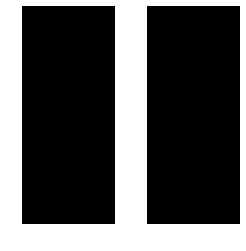

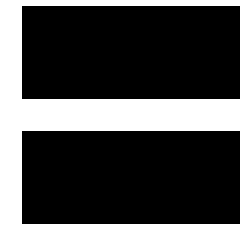

In [8]:
fmap = np.zeros(shape=(7,7,1,2),dtype=np.float32) 
fmap[:,3,0,0] = 1 
fmap[3,:,0,1] = 1
plot_image(fmap[:,:,0,0])
plt.show()
plot_image(fmap[:,:,0,1])
plt.show()

In Tensorflow, each input image is typically represetned by a 3D tensor of shape `[height,width,channels]`. A mini-batch is represented as a 4D tensor of shape `[mini-batch size,height,width,channels]`. The weights of a convolutional layer are represented as a 4D tensor in the shape of $[f_n,f_w,f_{n'},f_n]$

In [ ]:
reset_graph() 

X = tf.placeholder(tf.float32,shape=(None,height,width,1)) 
feature_maps = tf.constant(fmap) 
convolution = tf.nn.conv2d(X,feature_maps,strides = [1,1,1,1],padding="SAME") 
# X is the input mini-batch (4d tensor) 
# feature_maps: set of filters to apply (also a 4D tensor) 
# strides: four-element 1D array. two central elements are the vertial and horizonal strides. 
# padding: either "VALID" or "SAME" 

In the above example, we pick the filter, but in CNN, these are trainable parameters. TensorFlow has a `tf.layers.conv2d()` that creates the filters variable for you. 

In [ ]:
with tf.Session() as sess: 
    output = convolution.eval(feed_dict={X: images})

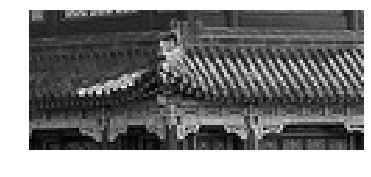

In [ ]:
plot_image(images[0,:,:,0])
plt.show() # Original

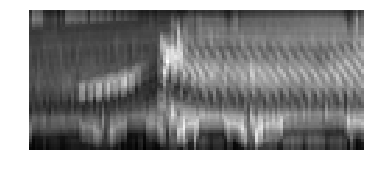

In [ ]:
plot_image(output[0,:,:,0])# Filtered by vertical 

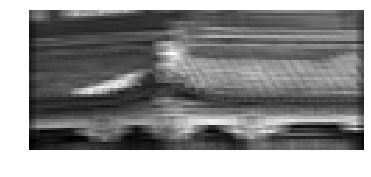

In [ ]:
plot_image(output[0,:,:,1]) # Filtered by horizonal 

# Pooling layer 
The goal is to subsample the input image in order to reduce the computational load, the memory usage, and the number of parameters. Pooling neuron has no weights, it aggregates the inputs. 

In [ ]:
dataset = np.array([china,flower],dtype=np.float32)
batch_size, height,width,channels = dataset.shape

filters = np.zeros(shape=(7,7,channels,2),dtype = np.float32) 
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

In [ ]:
X = tf.placeholder(tf.float32,shape=(None,height,width,channels),name="X") 
max_pool = tf.nn.max_pool(X,ksize=[1,2,2,1],strides = [1,2,2,1],padding="VALID")

with tf.Session() as sess: 
    output = sess.run(max_pool,feed_dict={X:dataset})


ksize: kernal size. TensorFlow doesn't support pooling over multiple instances. Therefore the first element on ksize must be 1. Also it doesn't support spatial pooling, therefore we will just use 

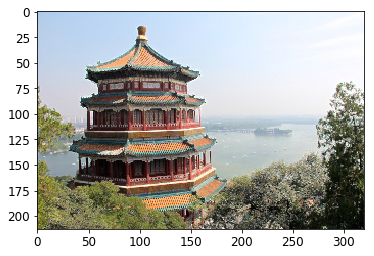

In [ ]:
plt.imshow(output[0].astype(np.uint8))

# MNIST 
The following code details how to implement CNN in tensorflow

In [ ]:
height = 28
width = 28
channels = 1
n_inputs = height * width 

conv1_fmaps = 32
conv1_ksize = 3 
conv1_stride = 1
conv1_pad = "SAME" 

conv2_fmaps = 64
conv2_ksize = 3 
conv2_stride = 2 
conv2_pad = "SAME" 

pool3_fmaps = conv2_fmaps 

n_fc1 = 64
n_outputs = 10

reset_graph() 

with tf.name_scope("inputs"): 
    X = tf.placeholder(tf.float32,shape=[None,n_inputs],name="X") 
    X_reshaped = tf.reshape(X,shape=[-1,height,width,channels])
    y = tf.placeholder(tf.int32,shape=[None])

conv1 = tf.layers.conv2d(X_reshaped,filters=conv1_fmaps,
                         kernel_size=conv1_ksize,strides=conv1_stride,
                         padding=conv1_pad,activation=tf.nn.relu,name="conv1")
conv2 = tf.layers.conv2d(conv1,filters=conv2_fmaps,
                        kernel_size=conv2_ksize,strides=conv2_stride,
                        padding=conv2_pad,activation=tf.nn.relu,name="conv2")

with tf.name_scope("pool3"): 
    pool3 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
    pool3_flat = tf.reshape(pool3,shape=[-1,pool3_fmaps*7*7])
with tf.name_scope("fc1"): 
    fc1 = tf.layers.dense(pool3_flat,n_fc1,activation=tf.nn.relu,name="fc1") 

    
with tf.name_scope("output"): 
    logits = tf.layers.dense(fc1,n_outputs,name="output")
    Y_proba = tf.nn.softmax(logits,name='Y_proba')
    
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y) 
    loss = tf.reduce_mean(xentropy) 
    optimizer = tf.train.AdamOptimizer() 
    training_op = optimizer.minimize(loss) 

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1) 
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

with tf.name_scope("init_and_save"): 
    init=tf.global_variables_initializer() 
    saver = tf.train.Saver() 


Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

The above code couldn't run because OS will say kernel has died. I think this is due to memory issue. 